In [1]:
import pandas as pd
import cv2
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

source = 0
deg_to_rad = np.pi/180
frames_per_s = 60
spat_freq = 0.08

In [2]:
df = pd.read_csv("cell_metrics_VISp.csv")

In [3]:
id_cols = [
    "experiment_container_id", "cell_specimen_id"
]

sg_cols = [
    "pref_ori_sg", "pref_sf_sg", "pref_phase_sg"
]

dg_cols = [
    "pref_dir_dg", "pref_tf_dg"
]

In [4]:
df = df[df["failed_experiment_container"]=="f"]
len(df)

63251

### Sample Dynamic Filters

In [5]:
df_dg = df[id_cols+dg_cols].dropna()

len(df_dg)

29635

In [6]:
df_dg

,experiment_container_id,cell_specimen_id,pref_dir_dg,pref_tf_dg
1,511498742,517397340,0.0,1.0
2,511498742,517397343,180.0,2.0
5,511498742,517397357,135.0,1.0
7,511498742,517397365,180.0,1.0
9,511498742,517397373,225.0,1.0
...,...,...,...,...
63241,712178509,738949092,0.0,2.0
63243,712178509,738949156,180.0,1.0
63245,712178509,738949207,0.0,2.0
63248,712178509,738949318,45.0,1.0


In [7]:
n_filters = 2

df_dg_sample = df_dg.sample(n_filters)

gs = [
    [
        cv2.getGaborKernel(
            ksize=(80,80),
            sigma=40,
            theta=r['pref_dir_dg']*deg_to_rad,
            lambd=1/spat_freq,
            gamma=1,
            psi=i*2*np.pi,
        )
        for i in np.linspace(0, 1, int(frames_per_s/r['pref_tf_dg']))
    ]
    for _, r in df_dg_sample.iterrows()
]

oris = [r['pref_dir_dg'] for _, r in df_dg_sample.iterrows()]
t_freqs = [r['pref_tf_dg'] for _, r in df_dg_sample.iterrows()]

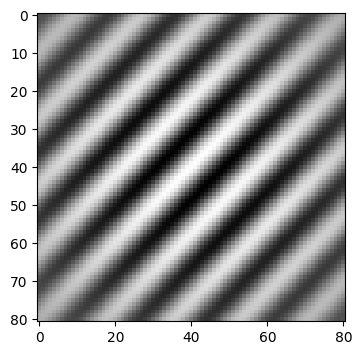

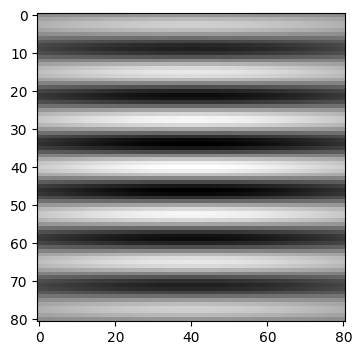

In [8]:
for g_t in gs:
    plt.figure(figsize=(5, 4))
    plt.imshow(g_t[0], cmap='gray')
    plt.show()

In [9]:
window_webcam = "Webcam"
window_filter = "Filter"

cv2.namedWindow(window_webcam, cv2.WINDOW_NORMAL)
for g_idx in range(len(gs)):
    cv2.namedWindow(f"{window_filter}_{g_idx}", cv2.WINDOW_NORMAL)

cam = cv2.VideoCapture(source)

In [10]:
_ret = True
filter_video = False
dts = []
frame_max = max([len(g) for g in gs])
frame_window = [None]*frame_max

In [11]:
frame_idx = 1

while _ret:
    start = time.time()
    
    _ret, frame = cam.read()
    frame = cv2.flip(frame, 1)
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray_mean = frame_gray.mean()
    frame_gray = (frame_gray - frame_gray_mean) / frame_gray_mean

    cv2.imshow(window_webcam, frame_gray)
    
    frame_window[1:] = frame_window[:-1]
    frame_window[0] = frame_gray
    
    if filter_video:
        # for g_idx, g_t in enumerate(gs):
        #     if frame_idx >= len(g_t):
        #         frames_conv = np.zeros((len(g_t),)+frame_gray.shape, dtype=np.float32)
        #         for i, g in enumerate(reversed(g_t)):
        #             frames_conv[i] = cv2.filter2D(
        #                 frame_window[i],
        #                 ddepth=cv2.CV_32F,
        #                 kernel=cv2.flip(g,-1),
        #                 borderType=cv2.BORDER_CONSTANT
        #             )
        #         frame_conv = np.sum(frames_conv, axis=0)
        #         frame_conv = (510*(frame_conv - frame_conv.min())/(frame_conv.max() - frame_conv.min()) -255)
        #         cv2.imshow(f"{window_filter}_{g_idx}", frame_conv)
        
        for g_idx, g_t in enumerate(gs):
            frame_conv = cv2.filter2D(
                frame_window[0],
                ddepth=cv2.CV_32F,
                kernel=cv2.flip(g_t[0],-1),
                borderType=cv2.BORDER_CONSTANT
            )
            frame_conv = (255*(frame_conv - frame_conv.min())/(frame_conv.max() - frame_conv.min())).astype(np.uint8)
            cv2.imshow(f"{window_filter}_{g_idx}", frame_conv)
        
    frame_idx += 1

    key = cv2.waitKey(5)
    if key == 27: # exit on ESC
        break
    if key == ord('1'):
        filter_video = not filter_video
        print('Video filtering is', ['off', 'on'][filter_video])
        
    end = time.time()
    dt = end-start
    dts.append(dt)

cv2.imwrite("last_frame.jpg", frame_gray)
np.save("dts.npy", np.array(dts))

In [12]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

# 